### Import related package

In [1]:
## Import tensorflow package for modeling
import torch
from torch.autograd import Variable
import torch.optim as optim

## Data processing
import pandas as pd
import numpy as np

## Min-max normalization
from sklearn.preprocessing import MinMaxScaler

## Plot the graph
import matplotlib.pyplot as plt
%matplotlib inline

## Initializing module
from sklearn.linear_model import LinearRegression
np.set_printoptions(suppress=True)

## Copy module
import copy

## Used to calculate the training time
import time

## Set the GUP environment
import os
import sys

from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker

In [2]:
## Set up the display
torch.set_printoptions(sci_mode=False)

### Control memory usage space for GPU

In [3]:
## 查詢有無可用 GPU
torch.cuda.is_available()
## 查詢可用 GPU 的數量
torch.cuda.device_count()
##目前設備
print("目前設備：",torch.cuda.current_device())
## 目前設備名
print("目前設備名：",torch.cuda.get_device_name(0))

目前設備： 0
目前設備名： GeForce GTX 1070 Ti


In [4]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

## Print out some info

In [5]:
def accuracy_cacl(pred_value, actual_value):
    
#     yo, loss, tape = network.forward()
    performance = []
    performance.append(torch.mean(torch.abs(pred_value - actual_value)))
    performance.append(torch.mean(torch.abs((pred_value - actual_value) / actual_value))) 
    performance.append(torch.sqrt(torch.mean((pred_value - actual_value)**2)))
    
    for i in range(2000,3001,1000):
        correct_times = torch.nonzero(torch.abs(pred_value - actual_value) <= i, as_tuple =False)
        accuracy = correct_times.shape[0]/pred_value.shape[0]
        performance.append(accuracy)
                       
    return performance

In [6]:
def plot_result(name, pred_value, actual_value):
    
#     fig, ax = plt.subplots(2,2,figsize=(20,10), sharex=True, sharey=True)
    fig, ax = plt.subplots(1,figsize=(20,10), sharex=True, sharey=True)
#     ax.set_xlim(0,pred_value.shape[0])  
    
    
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.plot(pred_value, label="LLAAT")
    ax.plot(actual_value, label="Actual")
    ax.set_title("Forecasted performance for l=%d" %(1))
    ax.legend()
        
    #fig.text(0.5, 0, "Stage of training", ha='center', fontsize=20)
    #fig.text(0, 0.5, "Copper price value", va='center', rotation='vertical')

    fig.suptitle("In the %s process"%(name))
    fig.tight_layout()
#     fig.savefig("In the %s process in the M=%d window.png"%(name, block_index),dpi=300,bbox_inches='tight')

In [7]:
def plot_adopted_node(network):
    
    fig, ax = plt.subplots(figsize=(20,5))
#     ax.set_xticklabels([i for i in range(network.nb_node_acceptable.shape[0]+5)])
    
    ax.set_title("Total amount of adopted hidden nodes in the training process")
    ax.plot(network.nb_node_acceptable,"-o")

    ax.set_xlabel("Stage of training")
    ax.set_ylabel("Hidden nodes")
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#     fig.savefig("hidden nodes in the training process in the M=%d window"%(block_index),dpi=300,bbox_inches='tight')

In [8]:
def evaluation_table(evaluation_results, name, performance, nb_step4, nb_step6_1, nb_step6_2, time,adopted_hidden_node):

    
    new_result = pd.DataFrame({

        "Stage":name,
        "MAE" : round(performance[0].item(),2),
        "MAPE" : "%.2f"%(performance[1]*100).item(),
        "RMSE" : round(performance[2].item(),2),
        "Accuracy(2000)" : [round(performance[3]*100,2)],
        "Accuracy(3000)" : [round(performance[4]*100,2)],
        "Step4":nb_step4,
        "Step6.1":nb_step6_1,
        "Step6.2":nb_step6_2,
        "Time":time,
        "Adopted_hidden_node":adopted_hidden_node
    })

    evaluation_results = evaluation_results.append(new_result, ignore_index=True)
    
    return evaluation_results

In [9]:
def validation(network, nb_step4, nb_step6_1, nb_step6_2, x_train_scaled, y_train_scaled, x_test, y_test, start, end, evaluation_results_train, evaluation_results_test):

    ## Training_Step
    print("<<Training step>>")
    print("The training time(s):",end - start)
    time = end - start
    yo, loss= network.forward()
    
    ## N - outlier
    pre_train = yo.data.cpu()
    true_train = network.y.data.cpu()
    
    pred_value_train = torch.FloatTensor(sc.inverse_transform(pre_train))
    actual_value_train = torch.FloatTensor(sc.inverse_transform(true_train))
    accuracy_train = accuracy_cacl(pred_value_train,actual_value_train)
    
    ## B
    pred_value_test = torch.FloatTensor(sc.inverse_transform(network.forecast(x_test).data.cpu()))
    accuracy_test = accuracy_cacl(pred_value_test, y_test)
    
    total_time = nb_step4 + nb_step6_1 + nb_step6_2
    print("<<The percentage of each step>>")
    print("Step 4: %.2f%%"%((nb_step4/total_time)*100))
    print("Step 6.1: %.2f%%"%((nb_step6_1/total_time)*100))
    print("Step 6.2: %.2f%%"%((nb_step6_2/total_time)*100))

    print("-"*60)
    print("Total frequency of cramming occurrences:",nb_step6_2)

    print("-"*60)
    print("The amount of hidden node that be pruned:",network.nb_node_pruned)

    print("-"*60)
    adopted_hidden_node = network.nb_node_acceptable[-1].item()
    print("The amount of adopted hidden nodes:",network.nb_node_acceptable[-1].item())

    print("-"*60)
    print("<<Accuracy in training step>>")
    print("The MAE for l = 1: %.2f" %(accuracy_train[0]))
    print("The MAPE for l = 1: %.2f%%" %(accuracy_train[1]))
    print("The RMSE for l = 1: %.2f" %(accuracy_train[2]))
    print("The accuracy(2000) for l = 1: %.2f%%" %(accuracy_train[3]*100))
    print("The accuracy(3000) for l = 1: %.2f%%" %(accuracy_train[4]*100))

    print("-"*60)
    print("<<Accuracy in inferencing step>>")
    print("The MAE for l = 1: %.1f" %(accuracy_test[0]))
    print("The MAPE for l = 1: %.1f%%" %(accuracy_test[1]))
    print("The RMSE for l = 1: %.1f" %(accuracy_test[2]))
    print("The accuracy(2000) for l = 1: %.1f%%" %(accuracy_test[3]*100))
    print("The accuracy(3000) for l = 1: %.1f%%" %(accuracy_test[4]*100))
    print("-"*60)

    
    evaluation_table_train = evaluation_table(evaluation_results_train, "Training", accuracy_train,nb_step4, nb_step6_1, nb_step6_2, time,adopted_hidden_node)
    evaluation_table_test = evaluation_table(evaluation_results_test, "Inferencing", accuracy_test,nb_step4, nb_step6_1, nb_step6_2, time,adopted_hidden_node)
    pre_LDSS = sc.inverse_transform(network.forecast(x_test).data.cpu())
#     pd.DataFrame(pre_LDSS).to_csv("pre_LDSS_%d.csv"%(block_index), index=False)
    
#     if block_index%5==0:
    plot_result("training",pred_value_train, actual_value_train)
    plot_result("inferencing",pred_value_test, y_test)
    plot_adopted_node(network)
    
    return(evaluation_table_train, evaluation_table_test)

### Preprocessing the data

In [10]:
def read(path):
    return pd.read_csv(path)

In [11]:
def buildTrain(train, pastWeek=4, futureWeek=4, defaultWeek=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureWeek-pastWeek):
        X = np.array(train.iloc[i:i+defaultWeek])
        X = np.append(X,train["CCSP"].iloc[i+defaultWeek:i+pastWeek])
        X_train.append(X.reshape(X.size))
        Y_train.append(np.array(train.iloc[i+pastWeek:i+pastWeek+futureWeek]["CCSP"]))
    return np.array(X_train), np.array(Y_train)

### Min-max normalization

In [12]:
## Use min-max normalization to scale the data to the range from 1 to 0
sc = MinMaxScaler(feature_range = (0, 1))

### Design get_data() to get data

In [13]:
def get_data(futureWeek):
    
    ## Read weekly copper price data
    path = "WeeklyFinalData.csv"
    data = read(path)
    
    date = data["Date"]
    data.drop("Date", axis=1, inplace=True)
    
    ## Add time lag (pastWeek=4, futureWeek=1)
    x_data, y_data = buildTrain(data, futureWeek=futureWeek)


    return (x_data, y_data)

#     return (x_data, y_data)

### Network class

In [14]:
class Network(torch.nn.Module):
    
    def __init__(self, nb_neuro, x_train_scaled, y_train_scaled):
        
        super(Network, self).__init__()
        self.linear1 = torch.nn.Linear(x_train_scaled.shape[1], nb_neuro).cuda()
        self.linear2 = torch.nn.Linear(nb_neuro, 1).cuda()
        
        
        # Stop criteria - threshold
        self.threshold_for_error = 0.12
        self.threshold_for_lr = 1e-4
        
        # Input data 
        self.x = torch.FloatTensor(x_train_scaled).cuda()
        self.y = torch.FloatTensor(y_train_scaled).cuda()
        
        # Learning rate
        self.learning_rate = 1e-3
        
        # Whether the network is acceptable, default as False
        self.acceptable = False
        
        # Some record for experiment
        self.nb_node_pruned = 0
        self.nb_node_acceptable=torch.IntTensor([nb_neuro])
        
        self.limit = nb_neuro
        
    ## Forecast the test data
    def forecast(self, x_test):
    
        x_test = torch.FloatTensor(x_test).cuda()
        activation_value = self.linear1(x_test).clamp(min=0)
        forecast_value = self.linear2(activation_value)
       
        return forecast_value

    ## Reset the x and y data
    def setData(self, x_train_scaled, y_train_scaled):
        self.x = torch.FloatTensor(x_train_scaled).cuda()
        self.y = torch.FloatTensor(y_train_scaled).cuda()
    
    ## Add the new data to the x and y data
    def addData(self, new_x_train, new_y_train):

        self.x = torch.cat([self.x, new_x_train.reshape(1,-1).cuda()],0)
        self.y = torch.cat([self.y, new_y_train.reshape(-1,1).cuda()],0)
    
    ## forward operation
    def forward(self, reg_strength=0):
       
        y1 = self.linear1(self.x).clamp(min=0)
        yo = self.linear2(y1)

        # performance measure
        param_val= torch.sum(torch.pow(self.linear2.bias.data,2))+torch.sum(torch.pow(self.linear2.weight.data,2))+torch.sum(torch.pow(self.linear1.bias.data,2))+torch.sum(torch.pow(self.linear1.weight.data,2))
        reg_term= reg_strength/((self.linear2.bias.data.shape[0]*(self.linear2.weight.data.shape[1]+1)) +(self.linear1.bias.data.shape[0]*(self.linear1.weight.data.shape[1]+1)))*param_val
        loss = torch.nn.functional.mse_loss(yo,self.y)+reg_term
        loss = loss.cuda()
        return(yo, loss)

    # backward operation
    def backward_Adadelta(self,loss):    

        optimizer = optim.Adadelta(self.parameters(), lr=self.learning_rate)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### Initializing module (Check)

In [15]:
def initializing(network, initial_x, initial_y):
    print("Initializing module")
    ## Find each minimum output value y
    min_y = torch.min(initial_y, axis=0)
    ## Subtract min_y from each y
    res_y = initial_y-min_y.values
    
    ## Use linear regression to find the initial W1,b1,Wo,bo
    reg = LinearRegression().fit(initial_x, res_y)
    
    ## Set up the initial parameter of the network
    network.linear1.weight = torch.nn.Parameter(torch.FloatTensor(reg.coef_).cuda())
    network.linear1.bias = torch.nn.Parameter(torch.FloatTensor(reg.intercept_).cuda())
    network.linear2.weight=torch.nn.Parameter(torch.FloatTensor([[1]]).cuda())
    network.linear2.bias = torch.nn.Parameter(torch.FloatTensor(min_y.values).cuda())
    
#     print(reg.coef_)
#     print(reg.intercept_)

    ## Set up the acceptable of the initial network as True
    network.acceptable =True

### Selecting module (Check)

In [16]:
def selecting(network, x_train_scaled, y_train_scaled):
    
    print("<<Selecting module>>")
    loss = []
    temp_network = copy.deepcopy(network)
    
    ## Put each data into network to calculate the loss value
    for i in range(x_train_scaled.shape[0]):
        temp_network.setData(x_train_scaled[i].reshape(1,-1), y_train_scaled[i].reshape(-1,1))
        loss.append((temp_network.forward()[1].item(),i))
#         print(network.state_dict())
#         print(temp_network.y)
#         print("-"*20)
#         print(temp_network.forward()[1])
#         print("-"*20)
#     ## Sort the data according to the loss value from smallest to largest, and save the data index in sorted_index
    sorted_index = [sorted_data[1] for sorted_data in sorted(loss, key = lambda x:x[0])]
    
    
    ## Print out some info for debug
    print("The loss value of k:",loss[sorted_index[0]])
#     print("The second_loss value of k:",loss[sorted_index[1]])
    print("Selecting module finish!")
#     print("Loss",loss)
#     print(network.state_dict())
    
    return sorted_index

### Matching

In [17]:
# def matching(network):

#     times_enlarge=0
#     times_shrink=0
    
#     print("<<Matching module>>")
#     print("threshold_for_error:",network.threshold_for_error)
    
#     ## Set up the learning rate of the network
#     network.learning_rate = 1e-3
#     network.acceptable = False
#     initial_network = copy.deepcopy(network)

#     yo, loss = network.forward()
    
#     if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):
#         print("Matching finished (firstly) - the network is acceptable")
#         network.acceptable = True
# #         print("Matching firstly finished - the network is acceptable")
#         print("Number of enlarge:",times_enlarge)
#         print("Number of shrink:",times_shrink)
#         return(network)
    
#     else:
    
#         while True:

#             yo, loss = network.forward()
#             network_pre = copy.deepcopy(network)
#             loss_pre = loss
            
#             # Backward and check the loss performance of the network with new learning rate
#             network.backward_Adadelta(loss)
#             yo, loss = network.forward()

#             # Confirm whether the loss value of the adjusted network is smaller than the current one
#             if loss <= loss_pre and torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):
       
#                 network.acceptable = True
#                 print("Matching finished - the network is acceptable")
#                 print("Number of enlarge:",times_enlarge)
#                 print("Number of shrink:",times_shrink)
#                 return(network)

#             elif loss <= loss_pre:
                
#                 times_enlarge+=1
#                 network.learning_rate *= 1.2

#             else:         

#                 # Identify whether the current learning rate is less than the threshold
#                 if network.learning_rate <= network.threshold_for_lr:

#                     # If true, set the acceptable of the network as false and return it
#                     network.acceptable = False
#                     print("Matching finished - the network is Unacceptable")
#                     print("Number of enlarge:",times_enlarge)
#                     print("Number of shrink:",times_shrink)
#                     return(initial_network)

#                 # On the contrary, restore w and adjust the learning rate
#                 else:
                    
#                     # Restore the papameter of the network
#                     network = copy.deepcopy(network_pre)
#                     times_shrink+=1
#                     network.learning_rate *= 0.7

In [18]:
def matching(network):

    times_enlarge=0
    times_shrink=0
    
    print("<<Matching module>>")
    print("threshold_for_error:",network.threshold_for_error)
    
    ## Set up the learning rate of the network
    network.learning_rate = 1e-3
    network.acceptable = False
    initial_network = copy.deepcopy(network)
    yo, loss = network.forward()
    
    if torch.all(torch.abs(yo-network.y) < network.threshold_for_error):

        network.acceptable = True
        print("Matching(o) first finished - the network is acceptable")
        print("Number of enlarge:",times_enlarge)
        print("Number of shrink:",times_shrink)
        return(network)
    
    else:
        
        for i in range(10000):
            
            yo, loss = network.forward()
            network_pre = copy.deepcopy(network)
            loss_pre = loss
#             print("<前Loss>",loss)
#             print(network.state_dict())
            # Backward and check the loss performance of the network with new learning rate
            network.backward_Adadelta(loss)
            yo, loss = network.forward()
#             print("<後Loss>",loss)
#             print(network.state_dict())
            # Confirm whether the loss value of the adjusted network is smaller than the current one
            if loss <= loss_pre and torch.all(torch.abs(yo-network.y) < network.threshold_for_error):

                # If true, multiply the learning rate by 1.2
                network.acceptable = True
                print("Matching finished - the network is acceptable")
                print("Number of enlarge:",times_enlarge)
                print("Number of shrink:",times_shrink)
                return(network)

            elif loss <= loss_pre:
                
#                 print("*1.2")
                times_enlarge+=1
                network.learning_rate *= 1.2


            else:         

                # Identify whether the current learning rate is less than the threshold
                if network.learning_rate <= network.threshold_for_lr:

                    # If true, set the acceptable of the network as false and return it
                    network.acceptable = False
                    print("Matching finished - the network is Unacceptable")
                    print("Number of enlarge:",times_enlarge)
                    print("Number of shrink:",times_shrink)
                    return(initial_network)

                # On the contrary, restore w and adjust the learning rate
                else:
#                     print("*0.7")
                    # Restore the papameter of the network
                    network = copy.deepcopy(network_pre)
                    times_shrink+=1
                    network.learning_rate *= 0.7
                
        network.acceptable = False
        print("Matching的第%d回合"%(i+1))
        print("Matching finished - the network is Unacceptable")
        print("Number of enlarge:",times_enlarge)
        print("Number of shrink:",times_shrink)
        return(initial_network)

### Matching for reorganizing

In [19]:
def matching_for_reorganizing(network):

    times_enlarge=0
    times_shrink=0
    
    print("<<Matching module for reorganizing>>")
    print("threshold_for_error:",network.threshold_for_error)
    
    ## Set up the learning rate of the network
    network.learning_rate = 1e-3
    network.acceptable = False
    initial_network = copy.deepcopy(network)
    yo, loss = network.forward()
    
    if torch.all(torch.abs(yo-network.y) < network.threshold_for_error):

        network.acceptable = True
        print("Matching(o) first finished - the network is acceptable")
        print("Number of enlarge:",times_enlarge)
        print("Number of shrink:",times_shrink)
        return(network)
    
    else:
        
        for i in range(500):
            
            yo, loss = network.forward()
            network_pre = copy.deepcopy(network)
            loss_pre = loss
#             print("<前Loss>",loss)
#             print(network.state_dict())
            # Backward and check the loss performance of the network with new learning rate
            network.backward_Adadelta(loss)
            yo, loss = network.forward()
#             print("<後Loss>",loss)
#             print(network.state_dict())
            # Confirm whether the loss value of the adjusted network is smaller than the current one
            if loss <= loss_pre and torch.all(torch.abs(yo-network.y) < network.threshold_for_error):

                # If true, multiply the learning rate by 1.2
                network.acceptable = True
                print("Matching finished(o) - the network is acceptable")
                print("Number of enlarge:",times_enlarge)
                print("Number of shrink:",times_shrink)
                return(network)

            elif loss <= loss_pre:
                
#                 print("*1.2")
                times_enlarge+=1
                network.learning_rate *= 1.2


            else:         

                # Identify whether the current learning rate is less than the threshold
                if network.learning_rate <= network.threshold_for_lr:

                    # If true, set the acceptable of the network as false and return it
                    network.acceptable = False
                    print("Matching finished(o) - the network is Unacceptable")
                    print("Number of enlarge:",times_enlarge)
                    print("Number of shrink:",times_shrink)
                    return(initial_network)

                # On the contrary, restore w and adjust the learning rate
                else:
#                     print("*0.7")
                    # Restore the papameter of the network
                    network = copy.deepcopy(network_pre)
                    times_shrink+=1
                    network.learning_rate *= 0.7
                
        network.acceptable = False
        print("Matching的第%d回合"%(i+1))
        print("Matching finished - the network is Unacceptable")
        print("Number of enlarge:",times_enlarge)
        print("Number of shrink:",times_shrink)
        return(initial_network)

## Cramming module (Check)

In [20]:
def cramming(network):
    
    torch.random.manual_seed(0)
    print("<<Cramming module>>")
    print("threshold_for_error:",network.threshold_for_error)
    
    ## Find unsatisfied data:K
    yo, loss = network.forward()
    undesired_index = torch.nonzero(torch.abs(yo-network.y) > network.threshold_for_error+0.001, as_tuple =False)

    ## Print out the undesired_index for debug
    print("不滿足個數：",undesired_index.shape[0])
    print("The index of the undesired data:",undesired_index)

    
    if undesired_index.shape[0] == 1:
        
        # Unsatisfied situation
        ## Find the index of the unsatisfied data
        k_data_num = undesired_index[0][0]

        undesired_data = torch.reshape(network.x[k_data_num,:], [1,-1])

        ## Remove the data that does not meet the error term
        left_data = network.x[:k_data_num,:]
        right_data = network.x[k_data_num+1:,:]
        remain_tensor = torch.cat([left_data, right_data], 0)


        ## Use the random method to find out the gamma and zeta
        while True:

            ## Find m-vector gamma: r
            ## Use the random method to generate the gamma that can make the conditions met
            gamma = torch.rand(size=[1,network.x.shape[1]]).cuda()
            subtract_undesired_data = torch.sub(remain_tensor, undesired_data)
            matmul_value = torch.mm(gamma,torch.t(subtract_undesired_data))

            if torch.all(matmul_value != 0):
                break

        while True:

            ## Find the tiny value: zeta
            ## Use the random method to generate the zeta that can make the conditions met
            zeta = torch.rand(size=[1]).cuda()

            if torch.all(torch.mul(torch.add(zeta,matmul_value),torch.sub(zeta,matmul_value))<0):
                break

       

        k_l = undesired_index[0][1]
        
        ## The weight of input layer to hidden layer I
        w10 = gamma
        w11 = gamma
        w12 = gamma

        W1_new = torch.cat([w10,w11,w12],0)
        

        ## The bias of input layer to hidden layer I
        matual_value = torch.mm(gamma,torch.t(undesired_data))
       
        
        b10 = torch.sub(zeta,matual_value)
        b11 = -1*matual_value
        b12 = torch.sub(-1*zeta,matual_value)

        b1_new = torch.reshape(torch.cat([b10,b11,b12],0),[3])
        
#         print("b1_new",b1_new)


        ## The weight of hidden layer I to output layer
        gap = network.y[k_data_num, k_l]-yo[k_data_num, k_l]
#         print("gap:",gap)

        wo0_value = gap/zeta
        wo1_value = (-2*gap)/zeta
        wo2_value = gap/zeta

        Wo_new = torch.reshape(torch.cat([wo0_value,wo1_value,wo2_value],0),[1,-1])

        ## Add new neuroes to the network
        network.linear1.weight = torch.nn.Parameter(torch.cat([network.linear1.weight.data, W1_new]))
        network.linear1.bias = torch.nn.Parameter(torch.cat([network.linear1.bias.data, b1_new]))
        network.linear2.weight = torch.nn.Parameter(torch.cat([network.linear2.weight.data, Wo_new],1))


        yo, loss = network.forward()
        
        ## Determine if cramming is successful and print out the corresponding information
        if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):
            network.acceptable = True 
            print("Cramming success!")

        else:
            print("Cramming failed!")
    
    else:
        print("條件不合，不能Cramming")

### Regularizing module (Check)

In [21]:
def regularizing(network):

    print("<<Regularizing module>>")
    print("threshold_for_error:",network.threshold_for_error)
    ## Record the number of executions
    times_enlarge = 0
    times_shrink = 0
    ## Set up the learning rate of the network
    network.learning_rate = 1e-3

    ## Set epoch to 100
    for i in range(100):

        ## Store the parameter of the network
        network_pre = copy.deepcopy(network)
        yo, loss = network.forward(1e-3)
        loss_pre = loss

#         print("調整前的network")
#         print("<<變數>>")
#         print(network.state_dict())
#         print("<<Loss值>>")
#         print(loss)
#         print("差異")
#         print(torch.abs(yo-network.y))
        
        ## Backward operation to obtain w'
        network.backward_Adadelta(loss)
        yo, loss = network.forward(1e-3)
#         print("調整後的network")
#         print("<<變數>>")
#         print(network.state_dict())
#         print("<<Loss值>>")
#         print(loss)
#         print("差異")
#         print(torch.abs(yo-network.y))
         # Confirm whether the adjusted loss value is smaller than the current one
        if loss <= loss_pre:
            
            ## Identify that all forecast value has met the error term
            if torch.all(torch.abs(yo-network.y) < network.threshold_for_error):
                
                ## If true, multiply the learning rate by 1.2
#                 print("*1.2")
                network.learning_rate *= 1.2
                times_enlarge += 1
#                 print("Regularizing %d process - Enlarge"%i)
#                 print("第\"%d\"回合是成功執行regularizing"%(i+1))
#                 print("差異")
#                 print(torch.abs(yo-network.y))

            else:

                ## Else, restore w and end the process
                network = copy.deepcopy(network_pre)
                print("Regularizing結束-因為沒有顧好預測誤差")
                print("Number of enlarge:",times_enlarge)
                print("Number of shrink:",times_shrink)
#                 print("Regularizing result: Unable to meet the error term")
                return(network)

        # If the adjusted loss value is not smaller than the current one
        else:

            ## If the learning rate is greater than the threshold for learning rate
            if network.learning_rate > network.threshold_for_lr:
                
                ## Restore the w and multiply the learning rate by 0.7
                network = copy.deepcopy(network_pre)
#                 print("*0.7")
                network.learning_rate *= 0.7
                times_shrink += 1
#                 print("把Learning rate變小")
#                 print("Regularizing %d process - Shrink"%i)
             ## If the learning rate is smaller than the threshold for learning rate
            else:
                
                ## Restore the w
                network = copy.deepcopy(network_pre)
                print("Regularizing結束-Learning不能這麼小")
                print("Number of enlarge:",times_enlarge)
                print("Number of shrink:",times_shrink)
#                 print("Regularizing result: Less than the epsilon for the learning rate")
                return(network)

    print("第\"%d\"回合Regularizing module完畢"%(i+1))
    print("Number of enlarge:",times_enlarge)
    print("Number of shrink:",times_shrink)
    return(network)

### Reorganizing module (Check)

In [22]:
def reorganizing(network):
    print("<<Reorganizing module>>")
    print("threshold_for_error:",network.threshold_for_error)
    
    limit = 4
    if network.linear1.bias.shape[0] <= limit:
        network = regularizing(network)
        return(network)
    
    else:
        
        ## Set up the k = 1, and p = the number of hidden node
        k = 1
    #     p = network.W1.shape[1]
        p = network.linear1.weight.data.shape[0]

        while True:

            ## If k > p, end of Process
            if k > p or p<=limit:

                print("Reorganizing result: The final number of neuro is ",p)
                return(network)

            ## Else, Process is ongoing
            else:

                ## Using the regularizing module to adjust the network
                network = regularizing(network)

                ## Store the network and w
                network_pre = copy.deepcopy(network)

                ## Set up the acceptable of the network as false
                network.acceptable = False
                
            
                ## Ignore the K hidden node
                network.linear1.weight = torch.nn.Parameter(torch.cat([network.linear1.weight[:k-1],network.linear1.weight[k:]],0))
                network.linear1.bias = torch.nn.Parameter(torch.cat([network.linear1.bias[:k-1],network.linear1.bias[k:]]))
                network.linear2.weight = torch.nn.Parameter(torch.cat([network.linear2.weight[:,:k-1],network.linear2.weight[:,k:]],1))

                
                ## Using the matching module to adjust the network
                network = matching_for_reorganizing(network)

                print("是不是可以不要這個hidden node:",network.acceptable)

                ## If the resulting network is acceptable, this means that the k hidden node can be removed
                if network.acceptable:

                    print("Drop out the nero number: %d / %d" %(k, p))
                    network.nb_node_pruned += 1
                    ## p--
                    p-=1

                ## Else, it means that the k hidden node cannot be removed
                else:

                    ## Restore the network and w
                    network = copy.deepcopy(network_pre)
                    print("Cannot drop out the nero number: %d / %d" %(k, p))

                    ## k++
                    k+=1

初始值候選人 torch.Size([30])
Initializing module
<<Initializing後看一下差異>>
tensor([[    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000]], device='cuda:0', grad_fn=<AbsBackward>)
threshold_for_error: 0.31
現在訓練到第幾筆資料: 20
剩餘X 資料 torch.Size([357, 18])
剩餘Y 資料 torch.Size([357, 1])
現在要進去模型的數據，y= tensor([0.8040])
目前模型的Data狀態 torch.Size([20, 1])
<<預測值>>
tensor([[0.5669],
        [0.5265],
        [0.5514],
        [0.5638],
        [0.5590],
        [0.5611],
        [0.5558],
        [0.5479],
        [0.5264],
        [0.5406],
        [0.5366],
        [0.5340],
        [0.5329],
        [0.5230],
        [0.5696],
        [0.5413],
        [0.5251],

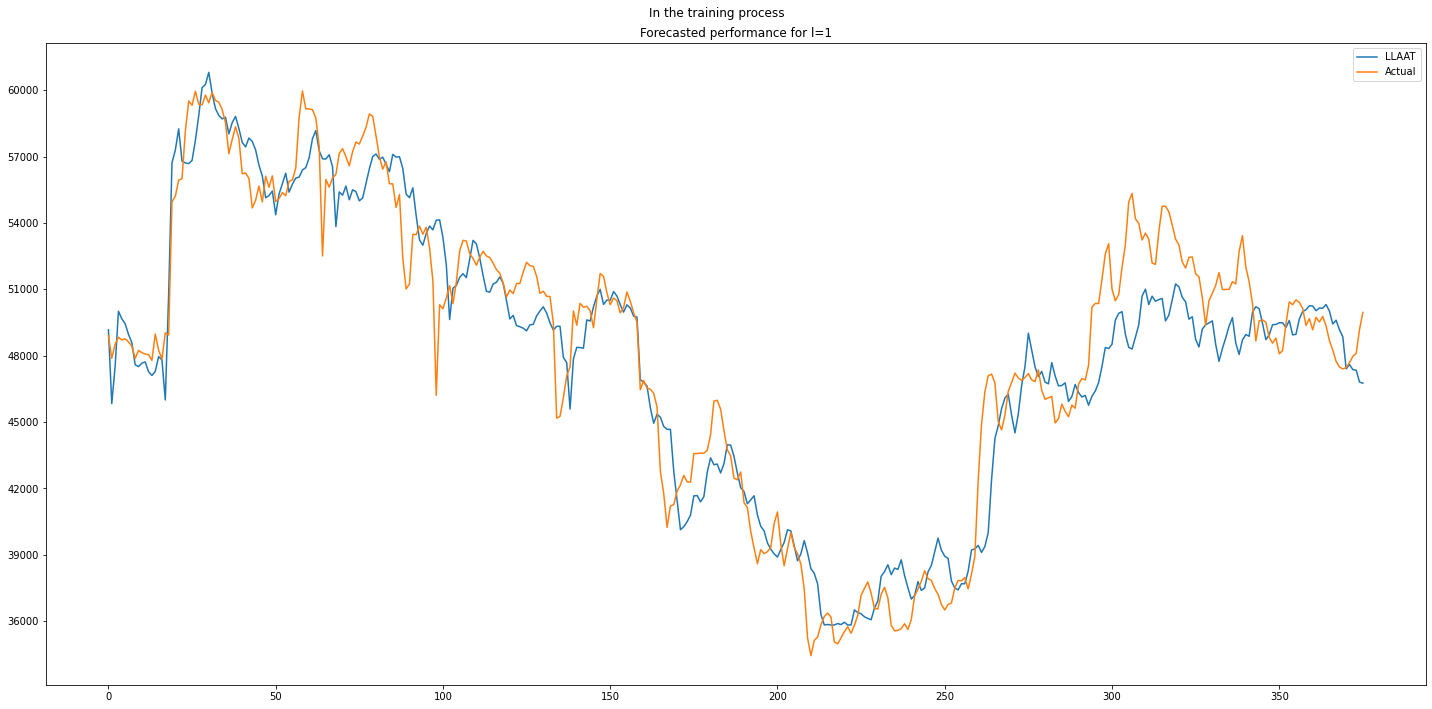

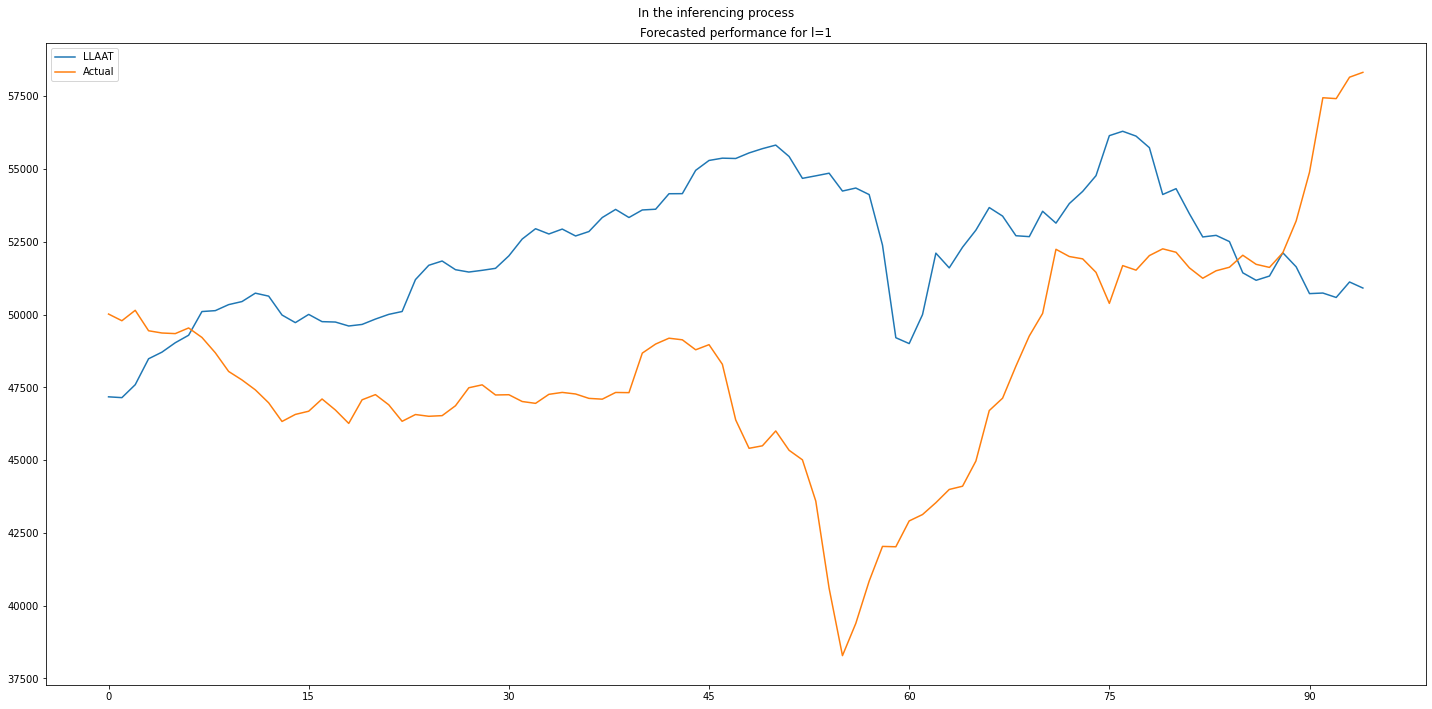

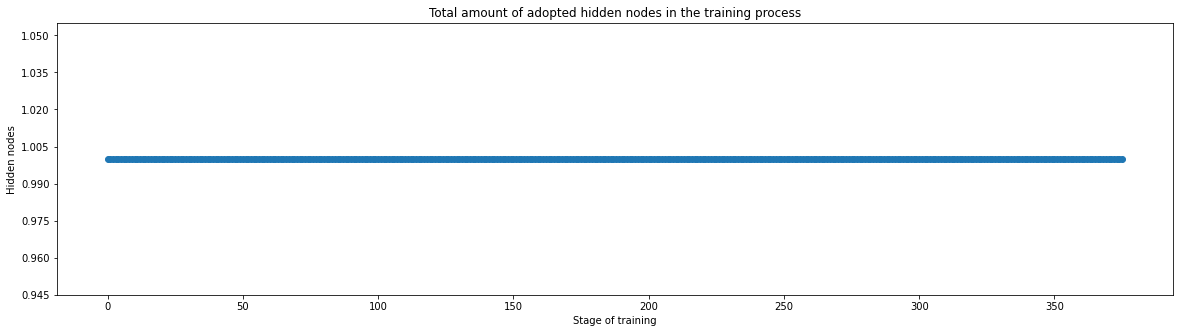

In [23]:
evaluation_table_train = pd.DataFrame(columns=["Stage","MAE","MAPE","RMSE","Accuracy(2000)","Accuracy(3000)","Step4","Step6.1","Step6.2","Time","Adopted_hidden_node"])
evaluation_table_test = pd.DataFrame(columns=["Stage","MAE","MAPE","RMSE","Accuracy(2000)","Accuracy(3000)","Step4","Step6.1","Step6.2","Time","Adopted_hidden_node"])
    
x_data, y_data= get_data(4)
x_data = sc.fit_transform(x_data)
y_data = sc.fit_transform(y_data[:,3].reshape(-1,1))
threshold_for_error = 8000/(sc.data_max_-sc.data_min_)

start = time.time()

## Record the number of each step
nb_step4 = 0
nb_step6_1 = 0
nb_step6_2 = 0


x_train = x_data[:int(x_data.shape[0]*0.8)]
x_test = x_data[int(x_data.shape[0]*0.8):]
y_train = y_data[:int(y_data.shape[0]*0.8)]
y_test = y_data[int(y_data.shape[0]*0.8):]

x_train_scaled = torch.FloatTensor(x_train)
x_test_scaled = torch.FloatTensor(x_test)
y_train_scaled = torch.FloatTensor(y_train)
y_test = sc.inverse_transform(y_test)

lower = torch.mean(y_train_scaled)-0.1*torch.std(y_train_scaled)
upper = torch.mean(y_train_scaled)+0.1*torch.std(y_train_scaled)
nonoutlier_index = torch.nonzero((y_train_scaled[:,0]>lower)&(y_train_scaled[:,0]<upper), as_tuple =False).reshape([-1])
print("初始值候選人",nonoutlier_index.shape)
initial_x = x_train_scaled[nonoutlier_index[:19]]
initial_y = y_train_scaled[nonoutlier_index[:19]]

x_train_scaled = np.delete(x_train_scaled, nonoutlier_index[:19], 0)
y_train_scaled = np.delete(y_train_scaled, nonoutlier_index[:19], 0)

network = Network(1,initial_x,initial_y)

network.nb_node_acceptable = torch.IntTensor([1 for _ in range(initial_x.shape[0])])
network.threshold_for_error = round(threshold_for_error[0],2)

initializing(network, initial_x, initial_y)

print("<<Initializing後看一下差異>>")
yo,loss = network.forward()
print(torch.abs(network.y-yo))
print("threshold_for_error:",network.threshold_for_error)

remainder =  x_train_scaled.shape[0]
nb_step4 += initial_x.shape[0]

for i in range(remainder):

    
    print("現在訓練到第幾筆資料: %d"%(i+x_train_scaled.shape[1]+2))

    print("剩餘X 資料",x_train_scaled.shape)
    print("剩餘Y 資料",y_train_scaled.shape)

#     sorted_index = selecting(network, x_train_scaled, y_train_scaled)


    ## Add new data for training
    print("現在要進去模型的數據，y=",y_train_scaled[0].data)        
    network.addData(x_train_scaled[0], y_train_scaled[0])
    print("目前模型的Data狀態",network.y.shape)
    x_train_scaled = x_train_scaled[1:]
    y_train_scaled = y_train_scaled[1:]

    yo,loss = network.forward()
    print("<<預測值>>")
    print(yo)
    print("<<差異>>")
    print(torch.abs(yo-network.y))
    print("threshold_for_error:",network.threshold_for_error)
    print("Loss值")
    print(loss)

    pre_network = copy.deepcopy(network)

    if not torch.all(torch.abs(network.y-yo)<=network.threshold_for_error):
        
        network.acceptable = False
        network = matching(network)

        print("<<Matching後看一下差異>>")
        yo,loss = network.forward()
        print(torch.abs(yo-network.y))
        print("threshold_for_error:",network.threshold_for_error)

        if network.acceptable == False:

            network = copy.deepcopy(pre_network)
            cramming(network)

            if network.acceptable == False:
                sys.exit("Cramming failed.")  

            print("<<Cramming後看一下差異>>")
            yo,loss = network.forward()
            print(torch.abs(yo-network.y))
            print("threshold_for_error:",network.threshold_for_error)
            nb_step6_2 += 1

        else:
            nb_step6_1 += 1

    else:
        nb_step4 += 1

    network = reorganizing(network)
    print("<<Reorganizing後看一下差異>>")
    yo,loss = network.forward()
    print(torch.abs(yo-network.y))
    print("threshold_for_error:",network.threshold_for_error)

    network.nb_node_acceptable = torch.cat([network.nb_node_acceptable, torch.IntTensor([network.linear1.bias.data.shape[0]])],0)
    print("看一下 hidden node")
    print(network.nb_node_acceptable)

    print("使用裝置",(list(network.parameters())[0].device))
    print("-"*90)

end = time.time()

print("<<The performance>>")
evaluation_table_train, evaluation_table_test = validation(network, nb_step4, nb_step6_1, nb_step6_2, x_train_scaled, y_train_scaled,x_test_scaled, y_test, start, end,evaluation_table_train,evaluation_table_test)

evaluation_table_train.to_csv("evaluation_table_train.csv",index=False)
evaluation_table_test.to_csv("evaluation_table_inferencing.csv",index=False)

print("花費時間(s)",end-start)